In [1]:
import pandas as pd
import missingno as msno
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def toBool(any):
    return 1.00 if bool(any) else 0.00


# Read csv and convert test features to bool
df = pd.read_csv('./covid.csv', low_memory=False, converters={'tests_units': toBool})
# Display all columns setting 
pd.set_option('display.max_columns', None)


labels = ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths','new_deaths', 'new_deaths_smoothed', 
                    'total_cases_per_million', 'new_cases_per_million','new_cases_smoothed_per_million', 
                    'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']


In [7]:
################# Check for null values ###############
df.isnull().values.any()

False

In [53]:
## Instellingen voor een correctie plot.
def plot_corr(df, size=81):
    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks


In [67]:

test = df.sample(n = 100)

## Alle Smooth columns verwijderen aangezien ze een afronding zijn.
#del test['new_cases_smoothed']
#del test['new_deaths_smoothed']
#del test['new_tests_smoothed']
#del test['new_cases_smoothed_per_million']
#del test['new_deaths_smoothed_per_million']
#del test['new_tests_smoothed_per_thousand']

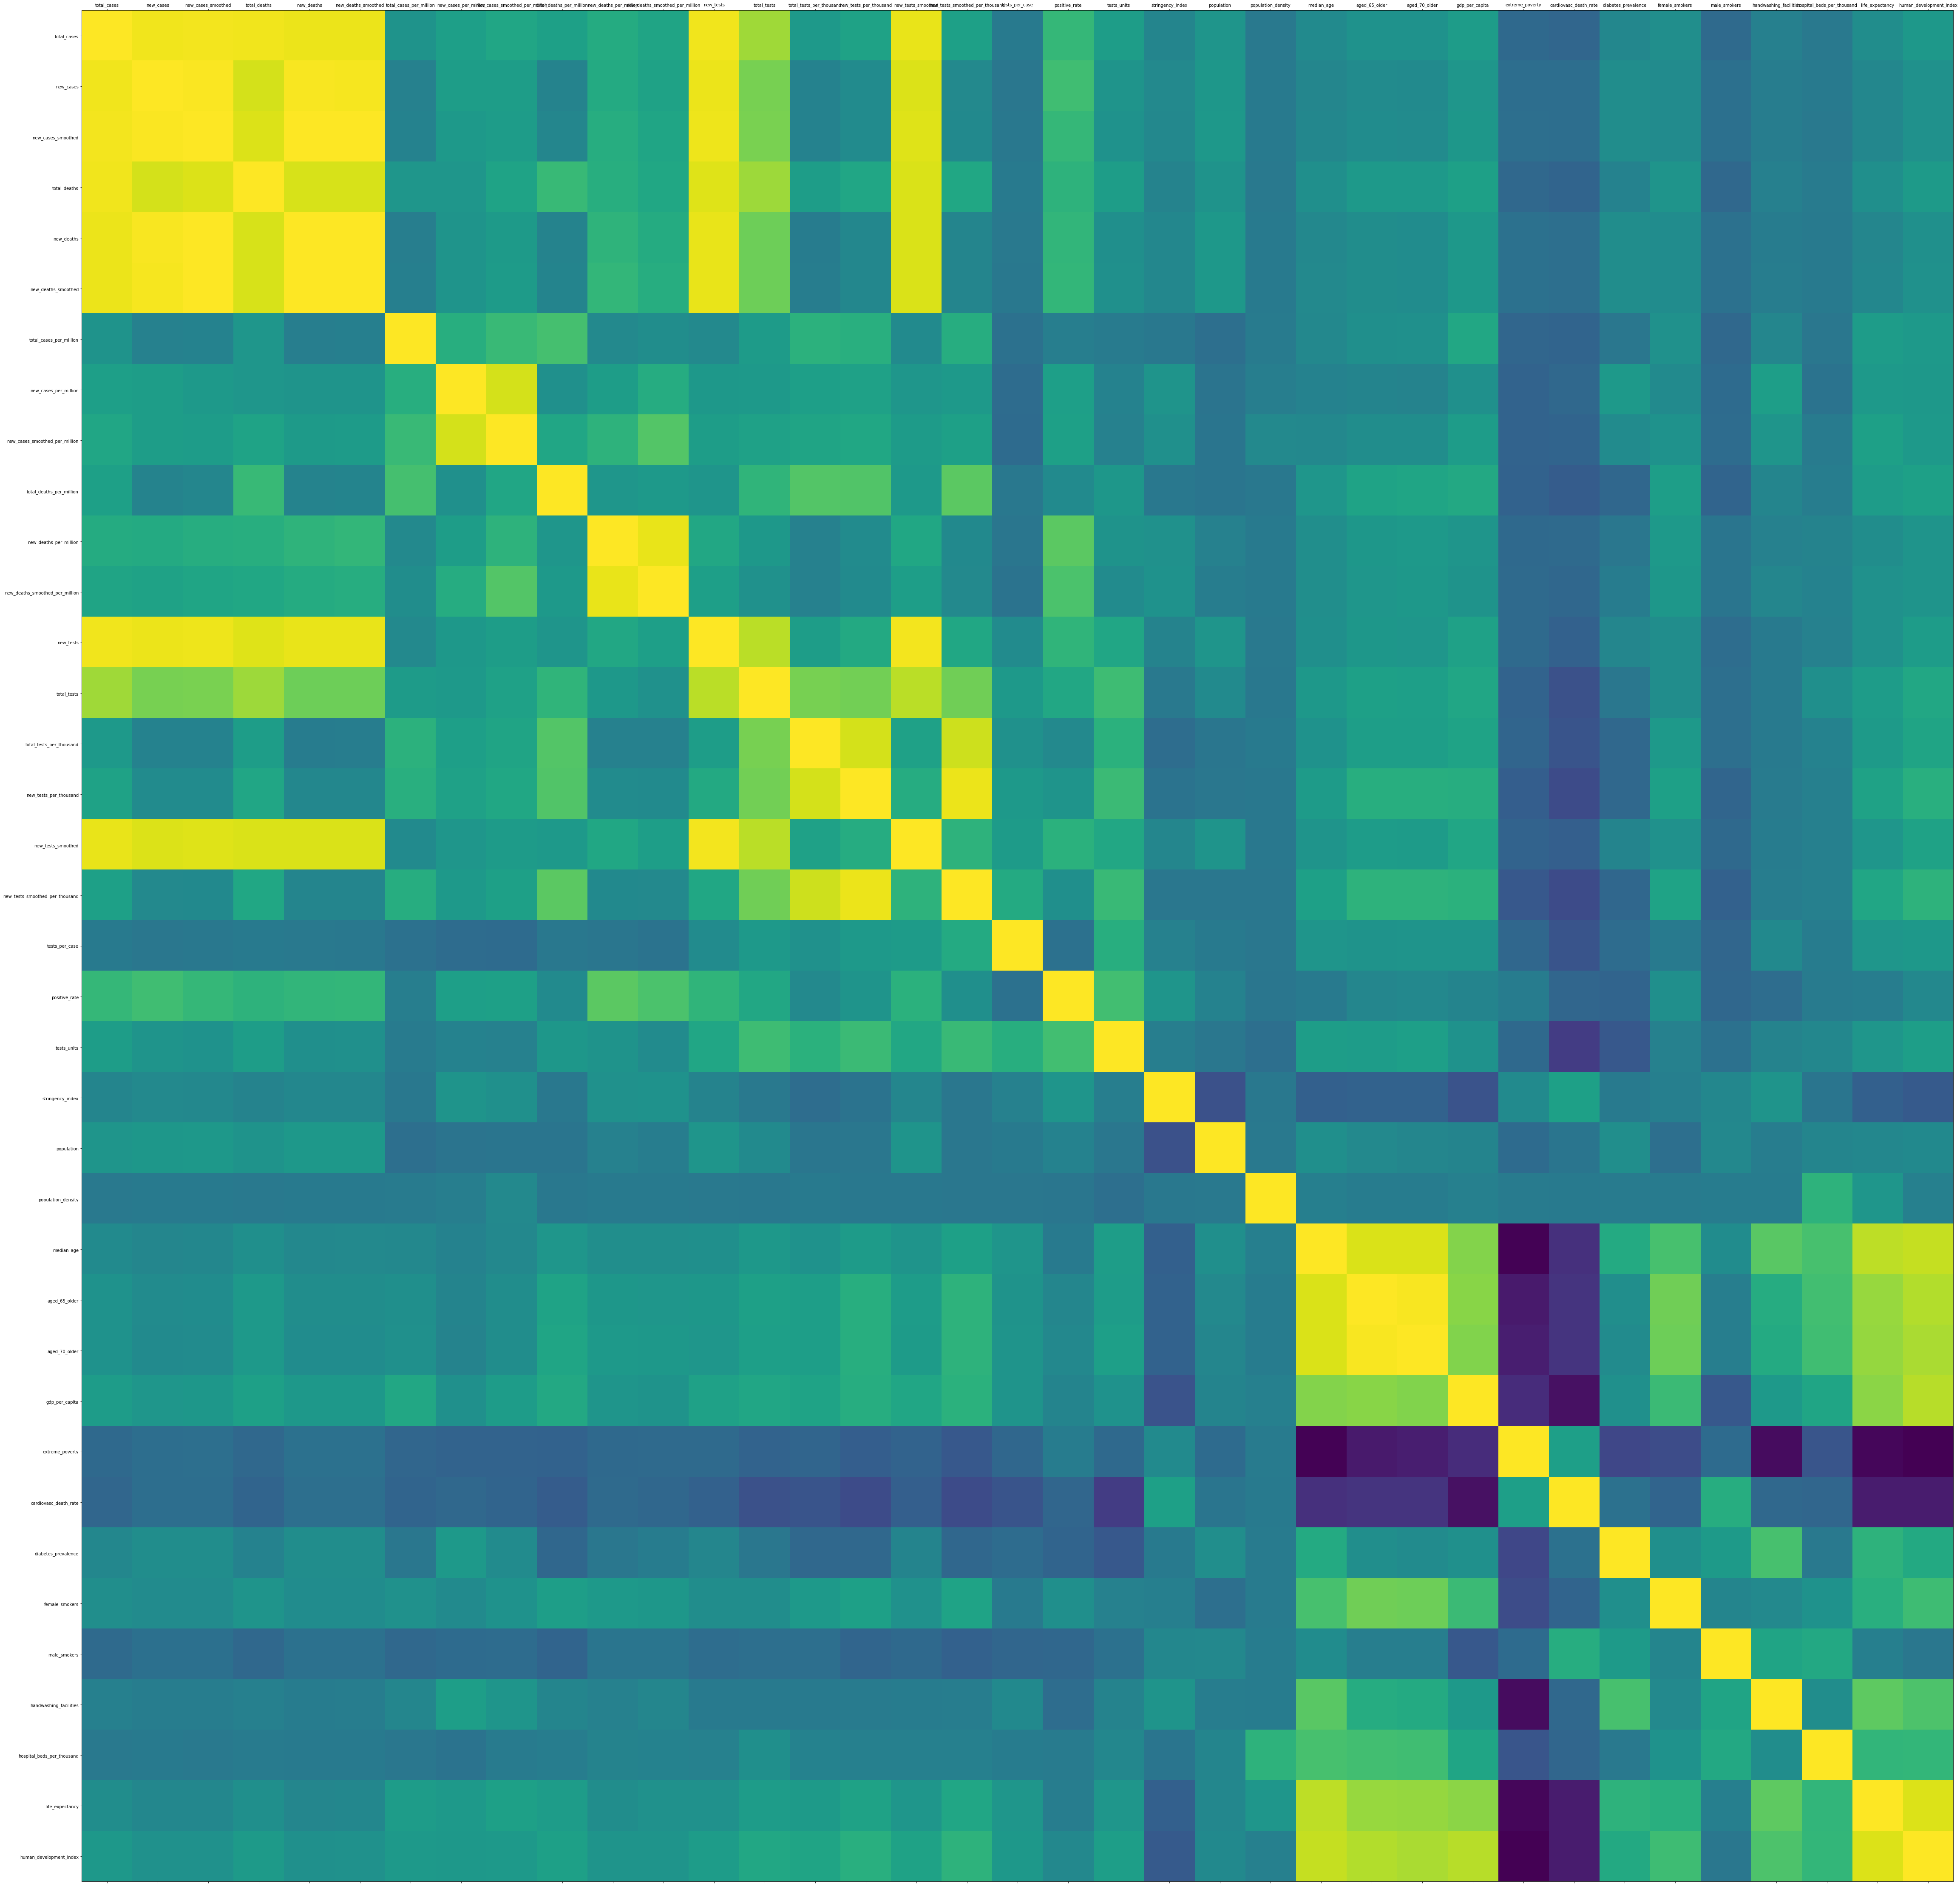

In [68]:
## Visuele tabel wat de correlatie laat zien tussen data.
## De GELER het vakje, de MEER correlatie er tussen zit
## Een correlatie laat zien dat tussen de twee waardes een verband zit, per 'stap' die waarde 1 omhoog of omlaag gaat, gaat waarde 2 ook omhoog of omlaag.

plot_corr(test)

In [66]:
## Tabel wat een correlation value laat zien tussen data
test.corr()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
total_cases,1.000000,0.871510,0.944056,0.894315,0.373746,0.450105,0.505636,0.287238,0.149343,0.221825,0.130659,0.091634,-0.019285,0.141235,0.196193,0.058918,0.155035,-0.023718,0.039627,-0.021095,-0.021606,-0.025036,-0.093264,-0.098474,-0.000908,0.010038,-0.085915,0.019804,-0.066257,0.053800,0.056095
new_cases,0.871510,1.000000,0.813702,0.986368,0.253075,0.457456,0.372675,0.295348,0.504382,0.321580,0.062867,0.065825,-0.045897,0.272596,0.252506,0.090649,0.372291,-0.050653,0.031748,-0.025316,-0.028126,-0.004706,-0.066603,-0.092355,0.022387,-0.005939,-0.097940,0.044039,-0.096591,0.026946,0.070956
total_deaths,0.944056,0.813702,1.000000,0.824508,0.331055,0.410207,0.642026,0.260952,0.175840,0.328604,0.165812,0.107478,-0.017581,0.088869,0.211986,0.011434,0.147143,-0.050855,0.115268,0.081834,0.085661,0.022690,-0.110081,-0.157932,-0.048274,0.090651,-0.089384,0.019492,-0.028475,0.112829,0.110610
new_deaths,0.894315,0.986368,0.824508,1.000000,0.242567,0.441160,0.354379,0.375903,0.430372,0.255773,0.029869,0.043197,-0.041124,0.201945,0.207535,0.085847,0.349227,-0.050584,0.035614,-0.016680,-0.020631,-0.008278,-0.069980,-0.088343,0.018915,-0.011738,-0.119503,0.031686,-0.099201,0.033578,0.068575
total_cases_per_million,0.373746,0.253075,0.331055,0.242567,1.000000,0.559482,0.532326,0.232216,0.069575,0.245861,0.470258,0.212562,-0.077587,0.195210,0.080700,-0.081200,-0.077971,0.121149,0.110302,-0.034814,-0.030310,0.264138,-0.082416,-0.184149,0.148655,0.099956,0.043137,0.064538,-0.001632,0.200190,0.169961
new_cases_per_million,0.450105,0.457456,0.410207,0.441160,0.559482,1.000000,0.532304,0.635026,0.198935,0.311919,0.406971,0.240699,-0.102802,0.353859,0.194362,-0.038945,-0.013990,-0.058127,0.103169,0.015039,0.023028,0.126090,-0.188103,-0.135768,0.011660,0.145088,0.033646,0.170710,0.022782,0.101827,0.163866
total_deaths_per_million,0.505636,0.372675,0.642026,0.354379,0.532326,0.532304,1.000000,0.338514,0.225142,0.541043,0.484532,0.324338,-0.053803,0.091749,0.196383,-0.102305,-0.031008,-0.039676,0.252403,0.227300,0.242977,0.238966,-0.177552,-0.276688,-0.051431,0.339801,-0.021584,0.077725,0.052776,0.277631,0.262535
new_deaths_per_million,0.287238,0.295348,0.260952,0.375903,0.232216,0.635026,0.338514,1.000000,0.074978,0.102761,0.110467,0.088955,-0.078888,0.079079,0.015026,-0.043695,-0.014718,-0.095711,0.144468,0.154300,0.159492,0.102142,-0.188327,-0.113336,-0.099282,0.153249,-0.103909,0.120472,-0.009797,0.124536,0.181795
new_tests,0.149343,0.504382,0.175840,0.430372,0.069575,0.198935,0.225142,0.074978,1.000000,0.752931,0.298860,0.335005,0.015686,0.303742,0.380275,0.014677,0.524346,-0.012012,0.167453,0.147860,0.147198,0.151298,-0.065240,-0.152426,-0.008819,0.089955,-0.105551,0.043699,-0.024896,0.115443,0.196056
total_tests,0.221825,0.321580,0.328604,0.255773,0.245861,0.311919,0.541043,0.102761,0.752931,1.000000,0.577393,0.469123,0.018782,0.319066,0.433264,-0.104345,0.289114,-0.000350,0.253737,0.234986,0.245457,0.161771,-0.112170,-0.200042,-0.106292,0.186133,-0.017822,0.038726,0.032731,0.186693,0.238332


In [2]:
################# FIX INCOMPLETENESS OF DATASET #####################

# Removes international and world rows
df = df.drop(df[pd.isna(df.continent)].index)
# Removes rows where labels are NaN
for label in labels:
    df = df.drop(df[pd.isna(df[label])].index)
    

# Transforms test features to 0 if there was not tested (if test_units = 0 then there was not tested yet)
df.loc[df['tests_units'] == 0.00, 
       ['new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate']] \
        = 0, 0, 0, 0, 0, 0, 0, 0


# Transforms NaN values to the mean value of that feature
numeric_columns = df.select_dtypes(include='number').columns
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
df[numeric_columns] = pd.DataFrame(imputer.fit_transform(df[numeric_columns]))


# Removes rows where only Iso code etc. are filled
df.dropna(inplace=True)

# ---------------------- TODO: DETECT AND REMOVE OUTLIERS TO IMPROVE PERFORMANCE ------------------------------
## https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba



# Creates labels and features
non_numeric_features = df.select_dtypes(exclude='number').columns
features = df.drop(non_numeric_features, axis=1)
features = features.drop(labels, axis=1)



In [3]:
#################### Define what to predict(y) and what to predict by(X) #############
X = features
y = df['new_cases']



#################### Split data between learning and test data ################
# ---------------------- TODO: (not sure if needed for current y because R2 score is high, maybe for other Y) REMOVE BIAS FROM TRAIN AND TEST SPLITS ?  -> SOLVE BY USING K-FOLD ? ------------------------------
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size=0.2, random_state=0)

print('train sizes: X, y')
print(x_train.shape, y_train.shape)
print('test sizes: X, y')
print(x_test.shape, y_test.shape)

train sizes: X, y
(36564, 25) (36564,)
test sizes: X, y
(9141, 25) (9141,)


In [4]:
###################### TRAINING MODEL ####################

# Train a model
ml = LinearRegression()
ml.fit(x_train, y_train)

# Check coefficients
print('Coefficients:')
print(ml.coef_)

# Check intercept
print('Intercept:')
print(ml.intercept_)

Coefficients:
[ 3.08885981e-03 -4.34942715e-04  3.16278078e+00  5.22719377e+01
  9.08233358e-02 -5.23070299e+02 -3.11828412e-02  7.38577478e+03
 -5.23500886e+02  2.83810412e+00  1.46824760e-06  3.96055641e-03
  9.22320147e+01  2.24761561e+01 -2.34012518e+02 -1.89489056e-02
 -8.91919092e+00 -9.90125864e-01 -3.46483969e+01  1.22819601e+01
 -2.31112118e+01 -4.55275495e+00 -4.97973415e+01  1.66879831e+01
  4.66696397e+02]
Intercept:
-1247.8917678671398


Y predicted size
R2 Score:
0.7531699465897221
Mean squared error (MSE) 5526024.475751191
       Actual value  Predicted value   Difference
11240        1303.0      1100.018065   202.981935
34961        4248.0      2927.184959  1320.815041
31403          69.0       105.163201   -36.163201
10960          17.0      -166.619856   183.619856
13021         932.0       887.785105    44.214895
11621           6.0       558.688954  -552.688954
39983          16.0       -11.243863    27.243863
16263           2.0      -522.177293   524.177293
34730        1830.0       900.710107   929.289893
15027           0.0       184.455532  -184.455532
9350            3.0      -930.956677   933.956677
16717         209.0      2327.114295 -2118.114295
771             0.0       244.376845  -244.376845
46577           0.0        80.527628   -80.527628
2789          497.0      -101.803340   598.803340
32129           0.0        16.844498   -16.844498
17101         154.0       109.141251    44.858749
15273      

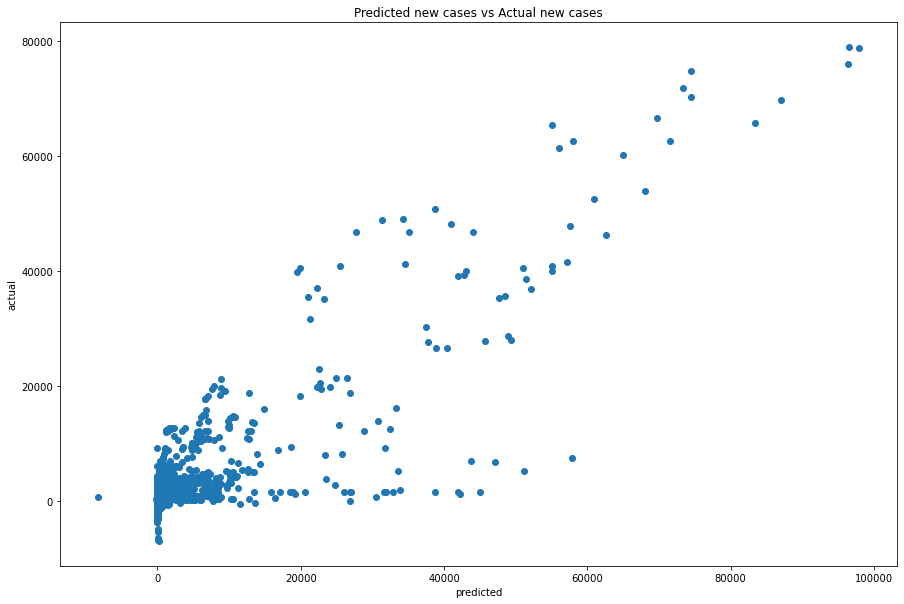

In [5]:
###################### MODEL PERFORMANCE #################

# Predict y
y_predicted = ml.predict(x_test)
print('Y predicted size')

# Validate predicted y
print('R2 Score:')
print(r2_score(y_test, y_predicted))
print('Mean squared error (MSE)', mean_squared_error(y_test, y_predicted))

# Display differences in numbers
pred_y_df = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_predicted, 'Difference': y_test - y_predicted})
print(pred_y_df[0:20])

# Visualize the validation results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_predicted)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Predicted new cases vs Actual new cases')
plt.show()


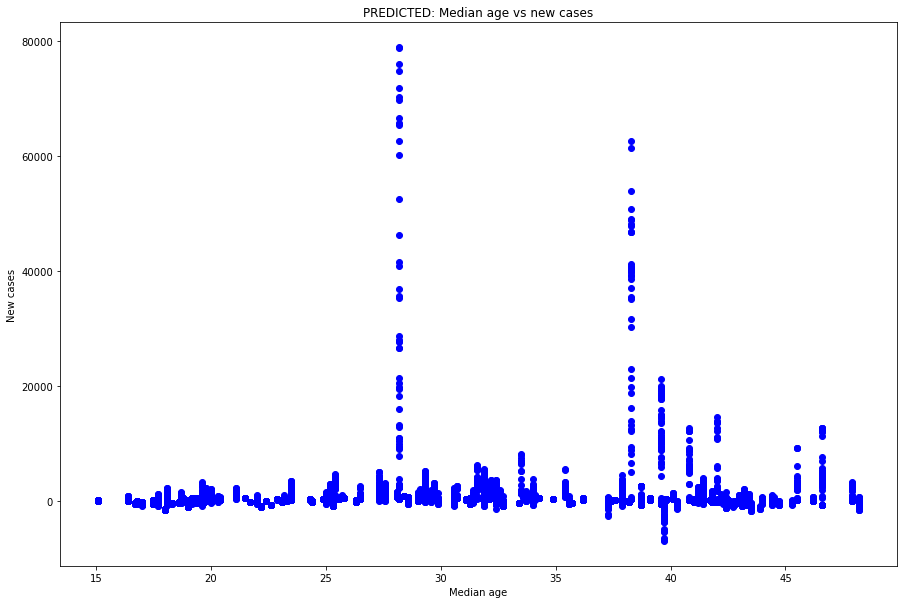

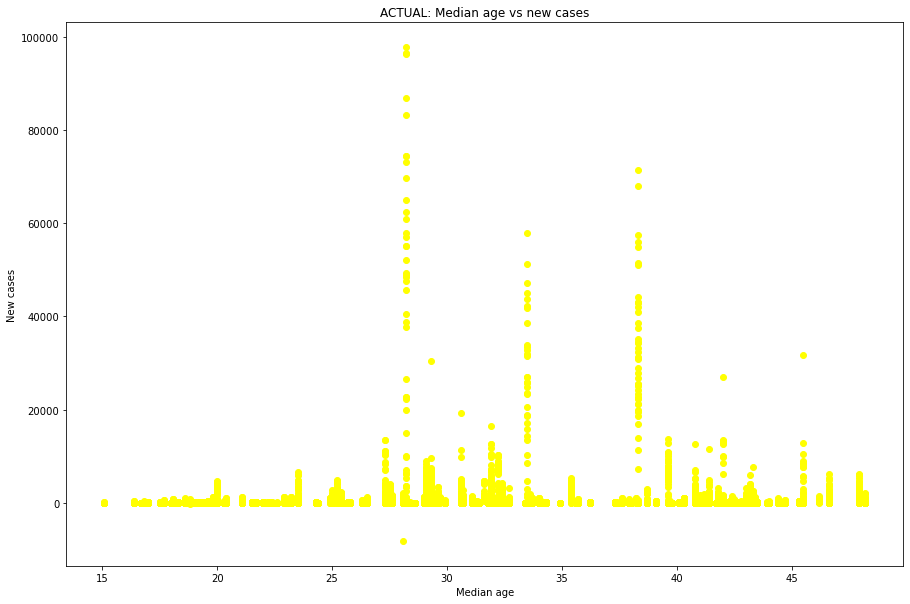

In [6]:
############### INSIGHTS #####################

#----------------- TODO: Visualize more insights -> causes for cases and deaths -------------------


# Visualize Insight 1:
plt.figure(figsize=(15, 10))
plt.xlabel('Median age')
plt.ylabel('New cases')
plt.title('PREDICTED: Median age vs new cases')
plt.scatter(x_test['median_age'], y_predicted, color='blue')
plt.show()

plt.figure(figsize=(15, 10))
plt.xlabel('Median age')
plt.ylabel('New cases')
plt.title('ACTUAL: Median age vs new cases')
plt.scatter(x_test['median_age'], y_test, color='yellow')
plt.show()
